# LeNet

In this notebook, we will be implementing a modified version of [LeNet-5](http://yann.lecun.com/exdb/lenet/), a neural network model that uses convolutional neural network (CNN) layers and was designed for [classifying handwritten characters](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). CNNs are ubiquitous in modern computer vision. Almost every neural network model for computer vision contains many CNN layers, also referred to as convolutional layers, thus they're an important concept to understand. We will explain how they work when we implement the model.

### Data Processing

As always, we'll import the modules we need...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

...set the random seed for reproducability...

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

...and calculate the mean and standard deviation across our training set so we can normalize our data.

In [3]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


Then, we'll define our train and test transforms...

In [4]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

...load our train and test data...

In [5]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

...and create a validation set from 10% of our training data.

Remember that the validation set should always be taken from the training data, and never the test data.

In [6]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

The validation set is using the same transforms as the training set, as it was created from it. As we want our validation set to remain static, to better resemble our test set, we replace these with the test transforms - remembering to `deepcopy` the validation set.

In [7]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

We'll print out the number of examples in the training/validation/test sets to ensure everything has been loaded correctly.

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


The final part of the data processing stage is to create our dataloaders/iterators.

Again, we use a batch size of 64 and only shuffle the training data each epoch.

In [9]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Defining the Model

Now we've gone through all the concepts, we can implement our model.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)


In [10]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(16 * 4 * 4, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):

        # x = [batch size, 1, 28, 28]

        x = self.conv1(x)

        # x = [batch size, 6, 24, 24]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 6, 12, 12]

        x = F.relu(x)

        x = self.conv2(x)

        # x = [batch size, 16, 8, 8]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 16, 4, 4]

        x = F.relu(x)

        x = x.view(x.shape[0], -1)

        # x = [batch size, 16*4*4 = 256]

        h = x

        x = self.fc_1(x)

        # x = [batch size, 120]

        x = F.relu(x)

        x = self.fc_2(x)

        # x = batch size, 84]

        x = F.relu(x)

        x = self.fc_3(x)

        # x = [batch size, output dim]

        return x, h

The rest of the notebook is similar to the previous ones.

We'll create an instance of the model...

In [11]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

### Training the Model

We define our optimizer...

In [12]:
optimizer = optim.Adam(model.parameters())

...our loss function (which will also apply the softmax activation function)...

In [13]:
criterion = nn.CrossEntropyLoss()

...define the device (to put our model and data on the GPU, if we have one)...

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

...place the model and criterion on the device...

In [15]:
model = model.to(device)
criterion = criterion.to(device)

...define a function to calculate accuracy...

In [16]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...define a function that performs a training epoch...

In [17]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...define a function that performs an evaluation epoch...

In [18]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...and finally we can begin training!

Even though we have significantly fewer parameters, the model still takes around the same amount of time per epoch (convolutional layers are computationally expensive) and we train it a bit longer.

However, we beat the ~98% validation accuracy achieved by the multilayer perceptron model and achieve 99% validation accuracy.

In [19]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'LeNet-model.pt')

    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.418 | Train Acc: 86.45%
	 Val. Loss: 0.115 |  Val. Acc: 96.55%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.138 | Train Acc: 95.70%
	 Val. Loss: 0.080 |  Val. Acc: 97.64%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.102 | Train Acc: 96.76%
	 Val. Loss: 0.073 |  Val. Acc: 97.81%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.084 | Train Acc: 97.41%
	 Val. Loss: 0.057 |  Val. Acc: 98.27%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.070 | Train Acc: 97.76%
	 Val. Loss: 0.057 |  Val. Acc: 98.24%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.064 | Train Acc: 97.96%
	 Val. Loss: 0.063 |  Val. Acc: 98.16%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.061 | Train Acc: 98.16%
	 Val. Loss: 0.048 |  Val. Acc: 98.65%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.052 | Train Acc: 98.40%
	 Val. Loss: 0.046 |  Val. Acc: 98.68%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.052 | Train Acc: 98.41%
	 Val. Loss: 0.052 |  Val. Acc: 98.51%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.046 | Train Acc: 98.50%
	 Val. Loss: 0.044 |  Val. Acc: 98.79%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.047 | Train Acc: 98.55%
	 Val. Loss: 0.052 |  Val. Acc: 98.57%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.044 | Train Acc: 98.61%
	 Val. Loss: 0.043 |  Val. Acc: 98.89%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.042 | Train Acc: 98.68%
	 Val. Loss: 0.038 |  Val. Acc: 98.92%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.041 | Train Acc: 98.69%
	 Val. Loss: 0.041 |  Val. Acc: 98.98%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.039 | Train Acc: 98.73%
	 Val. Loss: 0.041 |  Val. Acc: 98.89%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.036 | Train Acc: 98.82%
	 Val. Loss: 0.048 |  Val. Acc: 98.74%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.037 | Train Acc: 98.81%
	 Val. Loss: 0.036 |  Val. Acc: 99.07%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.033 | Train Acc: 99.00%
	 Val. Loss: 0.040 |  Val. Acc: 98.81%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.034 | Train Acc: 98.93%
	 Val. Loss: 0.037 |  Val. Acc: 99.04%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Train Loss: 0.032 | Train Acc: 98.99%
	 Val. Loss: 0.039 |  Val. Acc: 98.89%


We load the parameters which performed the best on the validation set and then evaluate our performance on the test set.

Just like the validation accuracy, we get 99% test accuracy!

In [20]:
model.load_state_dict(torch.load('LeNet-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.028 | Test Acc: 99.13%


### Examining the Model

Much like the previous notebook, we'll examine our model by: plotting a confusion matrix, seeing which incorrect examples our model was most confident about, view our model's learned representations in two dimensions with PCA and t-SNE, and view the weights of our model.

First, we'll get the model's predictions across the test set...

In [21]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [22]:
images, labels, probs = get_predictions(model, test_iterator, device)

...and then get the predicted labels from the model's predictions.

In [23]:
pred_labels = torch.argmax(probs, 1)

Next, we'll plot the confusion matrix.

In [24]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

The only real problem the model seemed to have is predicting 2s as 7s.

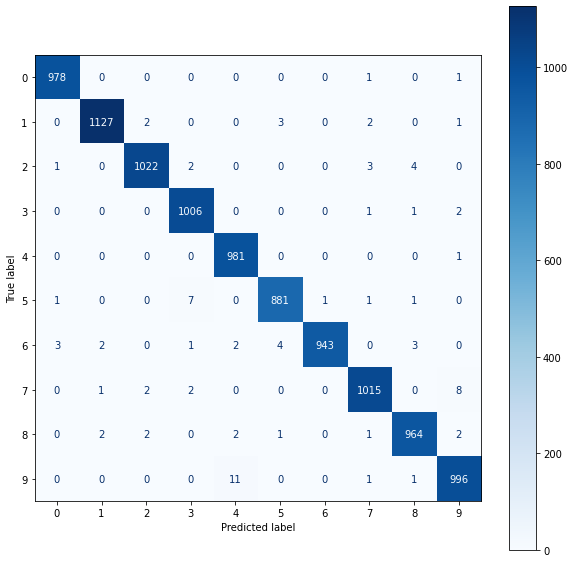

In [25]:
plot_confusion_matrix(labels, pred_labels)

Next, we'll find out which of our examples are correct...

In [26]:
corrects = torch.eq(labels, pred_labels)

print(type(pred_labels))

<class 'torch.Tensor'>


...then get all of the incorrect examples and sort them by descending confidence in their prediction.

In [27]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

We can then use this to plot the examples the model got wrong and was most confident about.

In [28]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

The mistakes look pretty reasonable. All the digits shown here are a bit off.

As mentioned in the previous notebook, the model is always trained to be incredibly confident with its predictions, so it's not unreasonable for it to be incredibly confident when it's wrong.

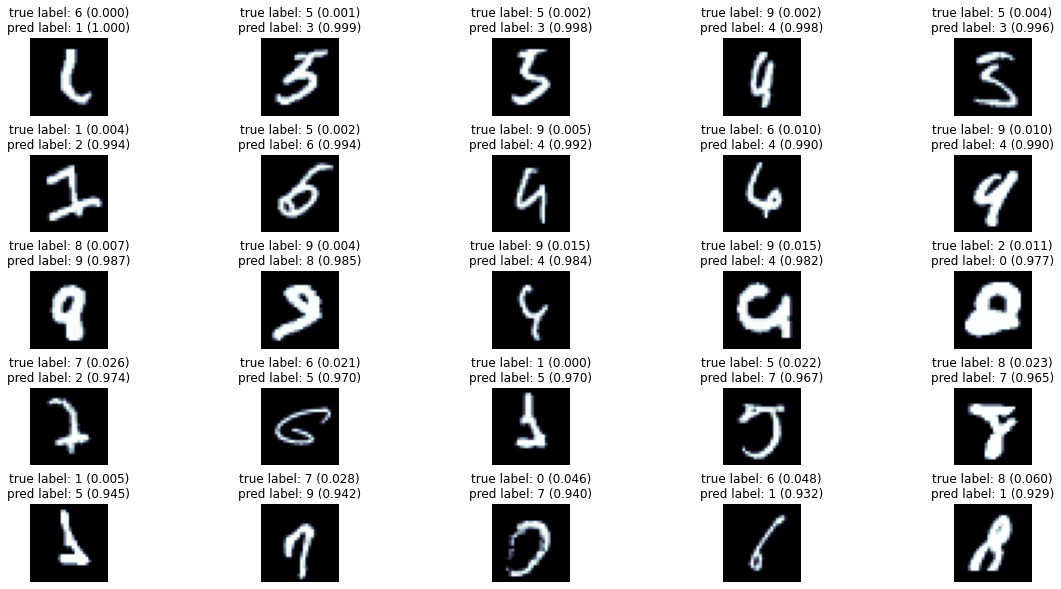

In [29]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

Let's move on to plotting the model's representations in lower dimensions, so we can visualize them.

First, we'll get the representations from the model...

In [30]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [31]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/844 [00:00<?, ?it/s]

...and then calculate PCA on the representations.

In [32]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [33]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

We then plot the PCA representations. 

Similar to the previous notebooks, even when the classes overlapped in the PCA representations, the confusion matrix showed that they weren't mixed up often at all.

In [34]:
output_pca_data = get_pca(outputs)

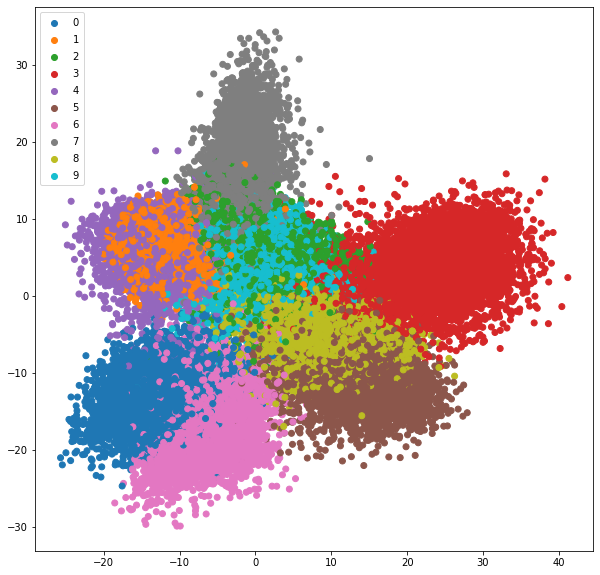

In [35]:
plot_representations(output_pca_data, labels)

Plotting the PCA representations of the intermediate values, just after the second set of convolutional and subsampling layers.

We can see that a lot of the classes are overlapped in one giant cluster. Intuitively, this makes sense, as the model has only extracted the features of the image so far and not yet passed them to the linear layers that will weight these features to make an actual prediction.

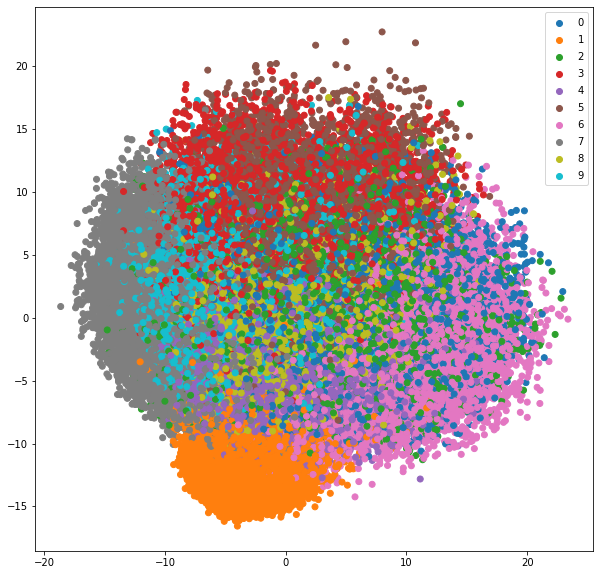

In [36]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

We repeat the process for t-SNE. Again, we only use a subset of the data, as t-SNE takes a considerable amount of time.

In [37]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

First, the output representations. t-SNE does a good job on separating out the classes.

/home/allan/anaconda3/envs/py3torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/allan/anaconda3/envs/py3torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


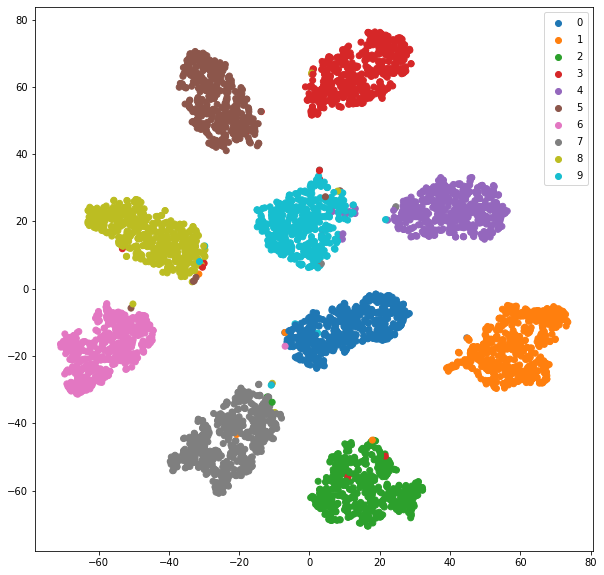

In [38]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

Again, the intermediate representations are more clustered, which adds more evidence to the theory that this is just a representation of the extracted features before the linear layers have had a chance to weight up evidence on the presence or absence of certain extracted features.

/home/allan/anaconda3/envs/py3torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/allan/anaconda3/envs/py3torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


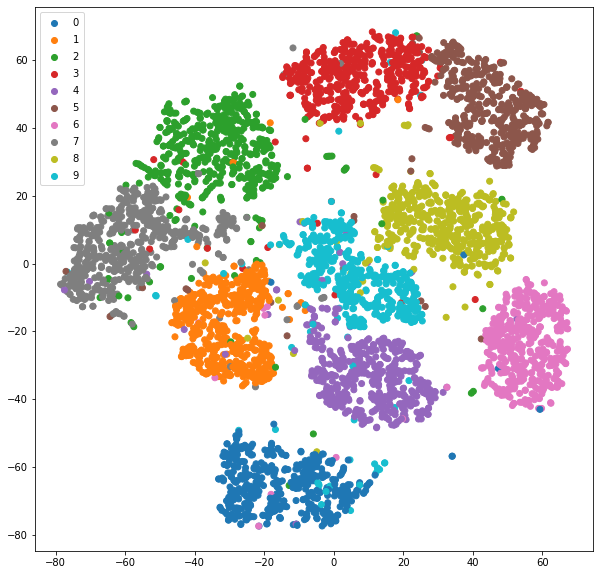

In [39]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

As before, we can try generating a perfect handwritten digit by repeatedly generating a batch of noise and storing the noise that gave us the highest probability of being the digit we want. 

Surely as we now have convolutional layers that look for edges and curves we should get something more sensible, right?

In [40]:
def imagine_digit(model, digit, device, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(32, 1, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

As we can see below, no. We get random noise with a >99% confidence that it's a three. 

Again, our model has been trained to be confident in its predictions and thus will be even for random noise. This is a flaw of neural networks and is a reason why [adversarial examples](https://openai.com/blog/adversarial-example-research/) work so well.

In [41]:
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [42]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 98.55%


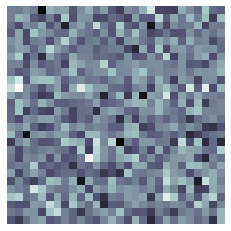

In [43]:
plt.imshow(best_image.squeeze(0).cpu().numpy(), cmap='bone')
plt.axis('off');

Remember how we defined the Sobel filters early on in this tutorial? Well, as convolutional layers learn their own values for their filters, we can do the same thing and see how our filters process images.

Let's define a function that takes a batch of images and multiple filters, which it then uses on the images.

In [44]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

Some of our filters look for areas of black pixels, which has the effect of inverting our images. Some apply a blur effect, which is similar to [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) effects used in image processing to reduce noise in the image. Some detect edges, like our Sobel filters we created earlier.

There is no guarantee each filter will learn a unique filtering effect. They are initialized randomly, and some filters may learn very similar weights. Therefore, it does not necessarily mean that using more filters will give a better performance.

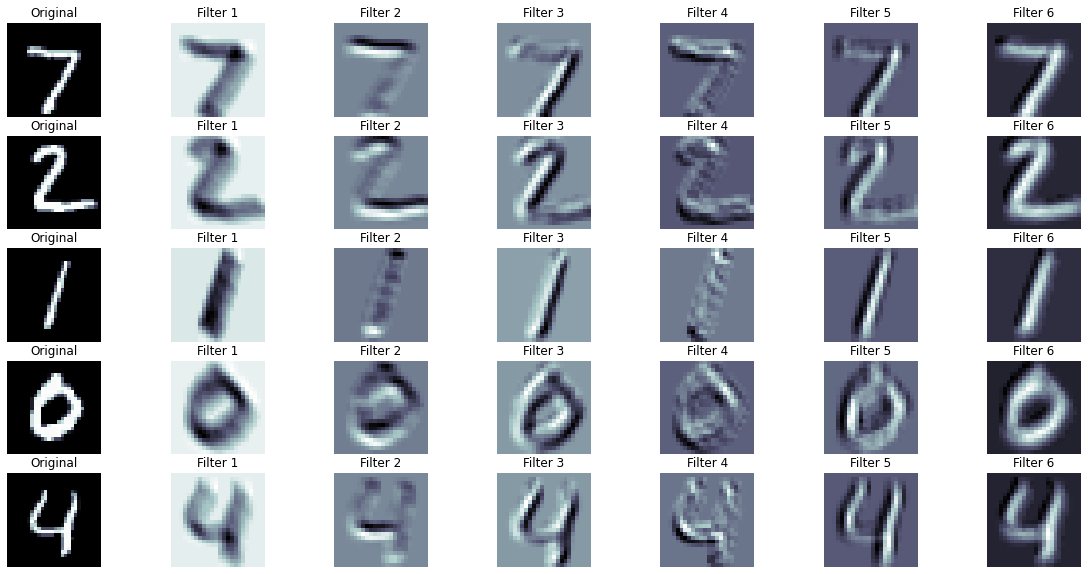

In [45]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters)

Let's see what our best imagined digit looks like after passing through our filters. 

We get some nice looking patterns, but that's about it. 

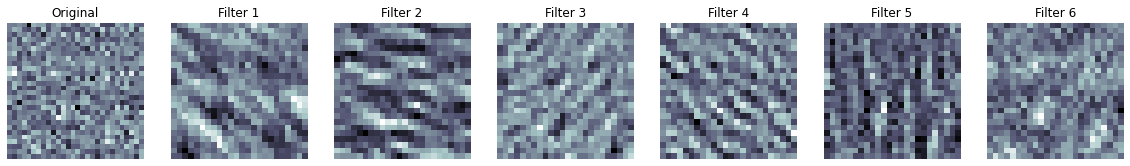

In [46]:
plot_filtered_images([best_image], filters)

Finally, we'll plot the actual filters themselves.

In [47]:
def plot_filters(filters):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_filters):

        ax = fig.add_subplot(1, n_filters, i+1)
        ax.imshow(filters[i].squeeze(0), cmap='bone')
        ax.axis('off')

There are some patterns visible, but it's difficult to interpret what these filters have actually learned.

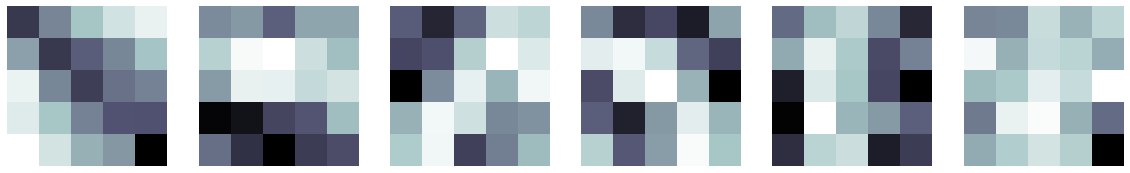

In [48]:
plot_filters(filters)